# Trilep analysis development



In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import os

from Tools.config_helpers import loadConfig, make_small
from klepto.archives import dir_archive

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.trilep_analysis import trilep_analysis
from processor.default_accumulators import desired_output, add_processes_to_output, variations

In [97]:
# an equivalent code can be run with ipython -i trilep_analysis.py within the processor directory

from Tools.samples import fileset_2018, fileset_2018_small

overwrite = False
year      = 2018
small     = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'trilep_analysis'
if small: cacheName += '_small'

cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

fileset = {
    'topW_v3': fileset_2018['topW_v3'],
    'topW_EFT_cp8': fileset_2018['topW_EFT_cp8'],
    'topW_EFT_mix': fileset_2018['topW_EFT_mix'],
    'TTW': fileset_2018['TTW'],
    'TTZ': fileset_2018['TTZ'],
    'TTH': fileset_2018['TTH'],
    'diboson': fileset_2018['diboson'],
    'ttbar': fileset_2018['top2l'],
    'DY': fileset_2018['DY'],
}

fileset = make_small(fileset, small, n_max=1)  # run over just one file each if small is set to true

# add all processes to output so that the cutflow doesn't fail
add_processes_to_output(fileset, desired_output)

# add some histograms that we defined in the processor
# everything else is taken the default_accumulators.py
from processor.default_accumulators import mass_axis, dataset_axis
desired_output.update({
    "dilep_mass": hist.Hist("Counts", dataset_axis, mass_axis),
})

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        trilep_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()


In [81]:
# we can just take the process list from the fileset to avoid any confusions
processes = list(fileset.keys())

processes.remove('topW_EFT_cp8')
processes.remove('topW_EFT_mix')

# the following list is directly taken from Tools/selection.py
lines = ['entry']
lines += [
            'filter',
            'lepveto',
            'trilep',
            'p_T(lep0)>25',
            'p_T(lep1)>20',
            'trigger',
            'offZ',
            'MET>50',
            'N_jet>2',
            'N_central>1',
            'N_btag>0',
            'N_fwd>0',
        ]

from Tools.helpers import getCutFlowTable
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY,S/B
entry,226.3 +/- 0.2,15200.0 +/- 30.0,12400.0 +/- 10.0,11630.0 +/- 10.0,748400.0 +/- 300.0,4391000.0 +/- 1000.0,89760000.0 +/- 20000.0,0.0000
filter,226.0 +/- 0.2,15180.0 +/- 30.0,12390.0 +/- 10.0,11610.0 +/- 10.0,748100.0 +/- 300.0,4390000.0 +/- 1000.0,89740000.0 +/- 20000.0,0.0000
lepveto,29.62 +/- 0.09,462.3 +/- 3.1,1872.0 +/- 3.0,488.8 +/- 1.2,30390.0 +/- 50.0,95420.0 +/- 110.0,323700.0 +/- 1100.0,0.0001
trilep,5.945 +/- 0.038,76.55 +/- 0.81,506.7 +/- 1.7,69.44 +/- 0.46,8279.0 +/- 27.0,202.9 +/- 4.5,1311.0 +/- 72.0,0.0006
p_T(lep0)>25,5.935 +/- 0.038,76.47 +/- 0.81,506.4 +/- 1.7,69.21 +/- 0.46,8265.0 +/- 27.0,201.4 +/- 4.5,1273.0 +/- 71.0,0.0006
p_T(lep1)>20,5.895 +/- 0.038,75.98 +/- 0.81,503.4 +/- 1.7,68.34 +/- 0.46,8217.0 +/- 27.0,196.8 +/- 4.5,1234.0 +/- 70.0,0.0006
trigger,5.685 +/- 0.037,73.06 +/- 0.8,484.7 +/- 1.7,64.89 +/- 0.45,7752.0 +/- 26.0,184.0 +/- 4.3,1052.0 +/- 65.0,0.0006
offZ,4.958 +/- 0.035,63.78 +/- 0.74,81.53 +/- 0.67,53.89 +/- 0.41,1080.0 +/- 10.0,151.1 +/- 3.9,530.9 +/- 45.0,0.0025
MET>50,4.072 +/- 0.031,51.43 +/- 0.67,56.58 +/- 0.56,42.87 +/- 0.37,554.7 +/- 7.1,103.7 +/- 3.2,49.71 +/- 13.99,0.0047
N_jet>2,3.557 +/- 0.029,29.53 +/- 0.54,45.99 +/- 0.51,34.0 +/- 0.33,95.47 +/- 2.96,41.36 +/- 1.96,10.74 +/- 6.65,0.0138


In [82]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY
entry,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
filter,0.9987,0.9987,0.9988,0.9987,0.9995,0.9996,0.9998
lepveto,0.1310,0.0305,0.1511,0.0421,0.0406,0.0217,0.0036
trilep,0.2007,0.1656,0.2706,0.1420,0.2724,0.0021,0.0041
p_T(lep0)>25,0.9984,0.9990,0.9994,0.9968,0.9983,0.9927,0.9711
p_T(lep1)>20,0.9933,0.9936,0.9942,0.9875,0.9942,0.9772,0.9690
trigger,0.9643,0.9616,0.9629,0.9495,0.9434,0.9346,0.8524
offZ,0.8721,0.8729,0.1682,0.8304,0.1394,0.8214,0.5049
MET>50,0.8213,0.8064,0.6940,0.7955,0.5134,0.6861,0.0936
N_jet>2,0.8736,0.5742,0.8128,0.7931,0.1721,0.3990,0.2160


In [83]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot

# defining some new axes for rebinning.
N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
mass_bins = hist.Bin('mass', r'$M\ (GeV)$', 20, 0, 200)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

my_labels = {
    'topW_v3': 'top-W scat.',
    'topW_EFT_cp8': 'EFT, cp8',
    'topW_EFT_mix': 'EFT mix',
    'TTZ': r'$t\bar{t}Z$',
    'TTW': r'$t\bar{t}W$',
    'TTH': r'$t\bar{t}H$',
    'diboson': 'VV/VVV',
    'ttbar': r'$t\bar{t}$',
    'DY': 'Drell-Yan',
}

my_colors = {
    'topW_v3': '#FF595E',
    'topW_EFT_cp8': '#000000',
    'topW_EFT_mix': '#0F7173',
    'TTZ': '#FFCA3A',
    'TTW': '#8AC926',
    'TTH': '#34623F',
    'diboson': '#525B76',
    'ttbar': '#1982C4',
    'DY': '#6A4C93',
}

Data: 0 MC: 54.94


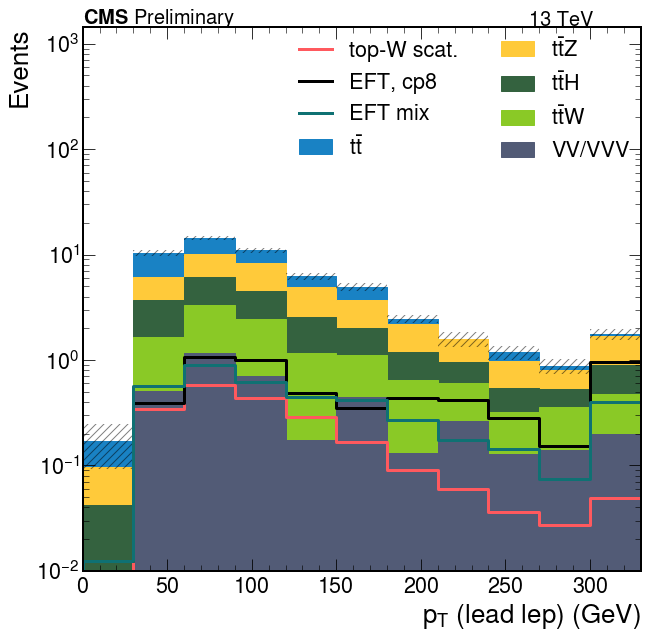

In [86]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=['topW_v3', 'topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 57.01


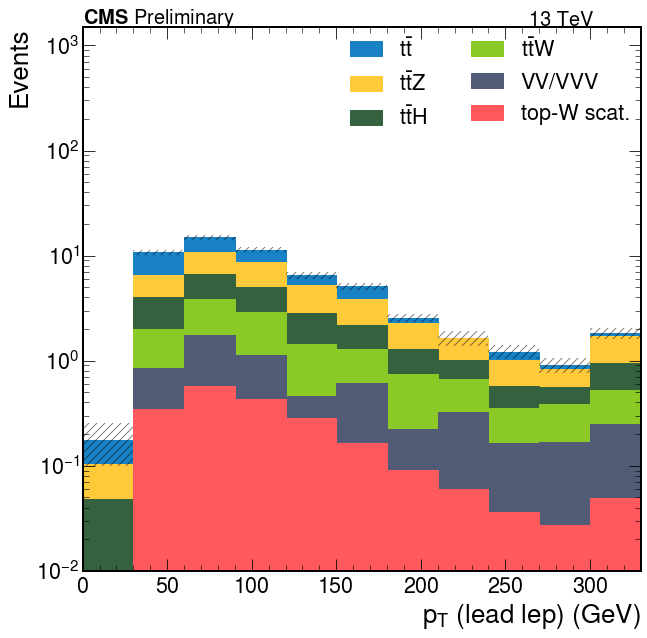

In [87]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 57.01


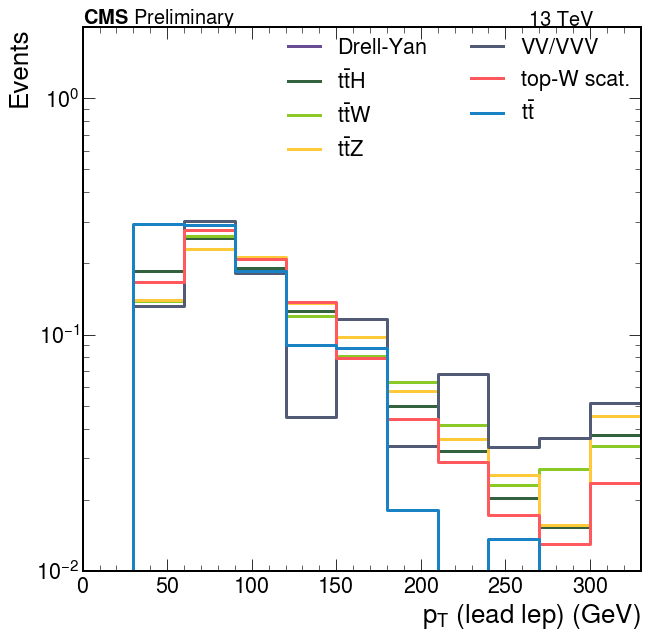

In [88]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 19.85


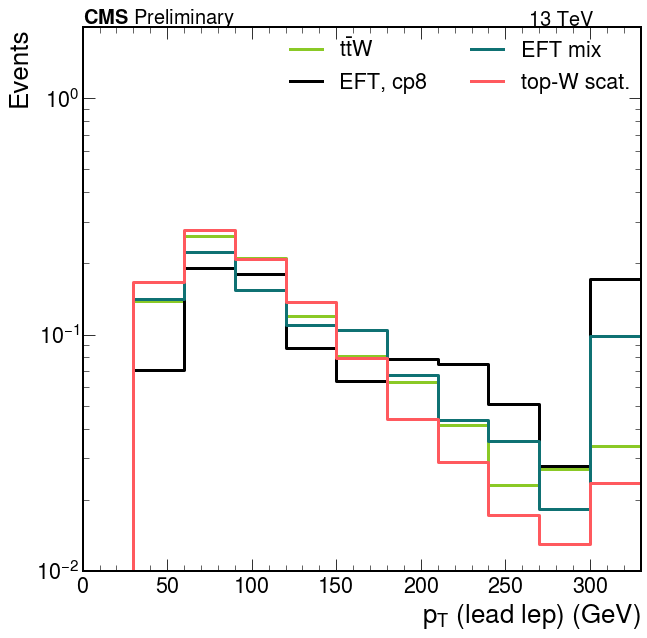

In [90]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         omit=['DY', 'ttbar', 'TTZ', 'TTH', 'diboson'],
        )

Data: 0 MC: 160.06
Data: 0 MC: 160.06


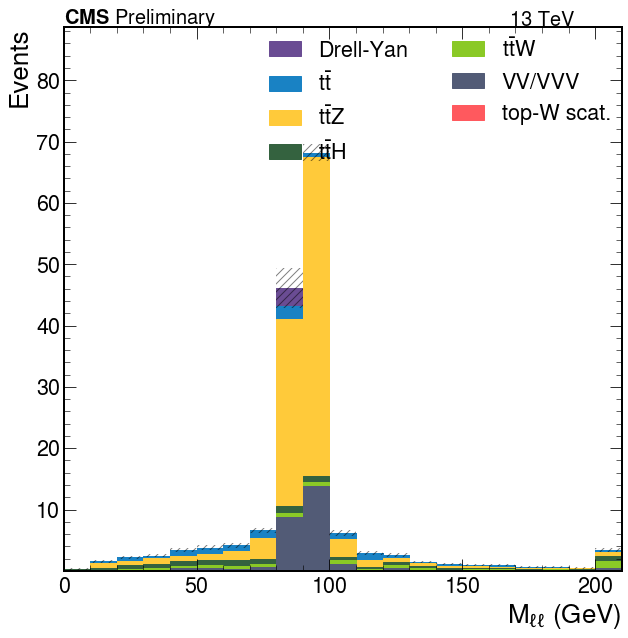

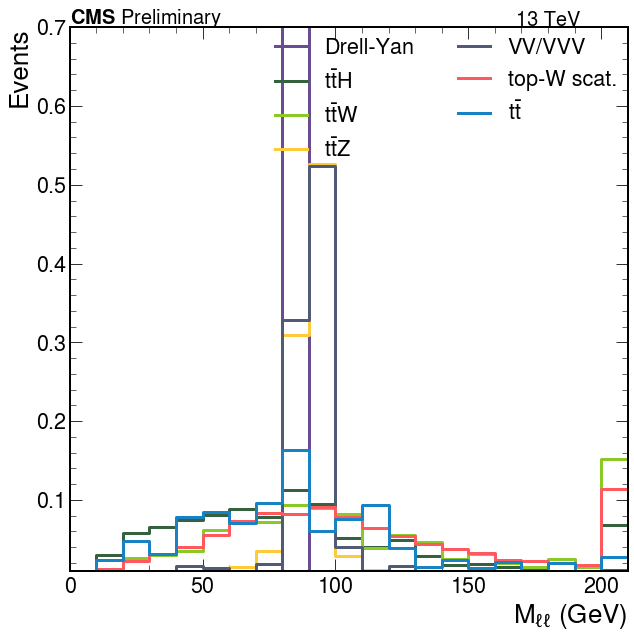

In [92]:
makePlot(output, 'dilep_mass', 'mass',
         bins=mass_bins, log=False, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson',  'TTW', 'TTH', 'TTZ', 'ttbar', 'DY'],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )
makePlot(output, 'dilep_mass', 'mass',
         shape=True,
         bins=mass_bins, log=False, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         ymax=0.7,
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )